## MovieDataLoader

In [291]:
import pandas as pd
import os

class MovieDataLoader:
    def __init__(self):
        """Initialize without parameters."""
        pass

    def load(self, file_path, encoding="utf-8"):
        """
        Load a single file into a DataFrame.

        Parameters:
        - file_path: str, the path to the file to load.
        - encoding: str, encoding to use for reading the file.

        Returns:
        - DataFrame: the loaded DataFrame.
        """
        try:
            # Check if the file exists
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"File not found: {file_path}")

            # Load data based on file extension
            if file_path.endswith(".csv"):
                return pd.read_csv(file_path, engine='c', encoding=encoding)
            elif file_path.endswith(".txt"):
                return pd.read_csv(file_path, delimiter='[|\t]', engine='python', header=None, encoding=encoding)
            else:
                raise ValueError("Unsupported file format. Only .csv and .txt are supported.")
        except FileNotFoundError as e:
            print(f"Error: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
        return None

    @staticmethod
    def remove_first_row(df):
        """Remove the first row of the DataFrame and reset column names."""
        df.columns = df.iloc[0]  # Set first row as column names
        df = df.iloc[1:]  # Remove the first row
        df.reset_index(drop=True, inplace=True)
        return df

    @staticmethod
    def change_datatype(df, column, dtype):
        """
        Change the data type of a specific column.
        가장 마지막에 호출해야 함(NaN값이면 터짐)
        """
        df[column] = df[column].astype(dtype)
        return df

    @staticmethod
    def fill_each_other(df, col1, col2):
        """Fill missing values in one column using values from another column."""
        df.loc[df[col1].isnull() & df[col2].notnull(), col1] = df[col2]
        df.loc[df[col2].isnull() & df[col1].notnull(), col2] = df[col1]
        df = df.dropna(subset=[col1, col2])  # Drop rows where both columns are null
        return df

    @staticmethod
    def fill_val(df, column, value):
        """Fill missing values in a specific column with a given value."""
        df[column] = df[column].fillna(value)
        return df

## Load Dataset

In [292]:
kmrd_path = "../../kmrd-small"
file_paths = {
    'countries.csv': f"{kmrd_path}/countries.csv",
    'movies.txt': f"{kmrd_path}/movies.txt",
    'genres.csv': f"{kmrd_path}/genres.csv",
    'rates.csv': f"{kmrd_path}/rates.csv",
    'peoples.txt': f"{kmrd_path}/peoples.txt",
    'castings.csv': f"{kmrd_path}/castings.csv",
}

loader = MovieDataLoader()

# Process 'countries.csv'
countries_df = loader.load(file_paths['countries.csv'])

# Process 'movies.txt'
movies_df = loader.load(file_paths['movies.txt'])
movies_df = MovieDataLoader.remove_first_row(movies_df)
movies_df = MovieDataLoader.fill_each_other(movies_df, 'title', 'title_eng')
movies_df = MovieDataLoader.fill_val(movies_df, 'grade', 'Unknown')
movies_df = MovieDataLoader.fill_val(movies_df, 'year', 0)
movies_df = MovieDataLoader.change_datatype(movies_df, 'year', int)
movies_df = MovieDataLoader.change_datatype(movies_df, 'movie', int)

# Process 'genres.csv'
genres_df = loader.load(file_paths['genres.csv'])

# Process 'rates.csv': Convert Unix timestamp to datetime
rates_df = loader.load(file_paths['rates.csv'])
rates_df['time'] = pd.to_datetime(rates_df['time'], unit='s')

# Process 'peoples.txt'
peoples_df = loader.load(file_paths['peoples.txt'])
peoples_df = MovieDataLoader.remove_first_row(peoples_df)
peoples_df = MovieDataLoader.fill_val(peoples_df, 'original', 'Unknown')
peoples_df = MovieDataLoader.change_datatype(peoples_df, 'people', int)

# Process 'castings.csv'
castings_df = loader.load(file_paths['castings.csv'])

In [293]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS: 'AppleGothic', Windows: 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [294]:

# # Print head of each DataFrame to verify
# print("Countries DataFrame:")
# print(countries_df.head())
# print(countries_df.info())

print("\nMovies DataFrame:")
print(movies_df.head())
print(movies_df.info())

# print("\nGenres DataFrame:")
# print(genres_df.head())
# print(genres_df.info())

print("\nRates DataFrame:")
print(rates_df.head())
print(rates_df.info())

# print("\nPeoples DataFrame:")
# print(peoples_df.head())
# print(peoples_df.info())

# print("\nCastings DataFrame:")
# print(castings_df.head())
# print(castings_df.info())



Movies DataFrame:
0  movie                 title                           title_eng  year  \
0  10001                시네마 천국              Cinema Paradiso , 1988  2013   
1  10002              빽 투 더 퓨쳐           Back To The Future , 1985  2015   
2  10003            빽 투 더 퓨쳐 2    Back To The Future Part 2 , 1989  2015   
3  10004            빽 투 더 퓨쳐 3  Back To The Future Part III , 1990  1990   
4  10005  스타워즈 에피소드 4 - 새로운 희망                    Star Wars , 1977  1997   

0    grade  
0   전체 관람가  
1  12세 관람가  
2  12세 관람가  
3   전체 관람가  
4       PG  
<class 'pandas.core.frame.DataFrame'>
Index: 992 entries, 0 to 998
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movie      992 non-null    int64 
 1   title      992 non-null    object
 2   title_eng  992 non-null    object
 3   year       992 non-null    int64 
 4   grade      992 non-null    object
dtypes: int64(2), object(3)
memory usage: 46.5+ KB
None

Rates DataFrame:


## RandomRecommender

In [295]:
import pandas as pd
import numpy as np

class RandomRecommender:
    def __init__(self, movies_df, rates_df):
        """
        Initialize with movies and ratings DataFrames.
        """
        self.movies_df = movies_df
        self.rates_df = rates_df

    def run(self, n=3, variation=50):
        """
        Generate random ratings and return the resulting DataFrame.
        
        Parameters:
        - n (int): Number of top results to return.
        - variation (int): Variation percentage for random error, applied as 1 ± (variation / 100).
        """
        # Convert variation to percentage-based float
        variation = variation / 100.0
        
        top_n_df = (self.movies_df.merge(self.rates_df, on="movie")
                    .assign(rate_random=lambda df: df["rate"] * np.random.uniform(1 - variation, 1 + variation, size=len(df)))
                    .groupby("movie", as_index=False)
                    .agg({"rate_random": "mean", "title": "first"})
                    .nlargest(n, "rate_random"))
    
        return top_n_df

1. DataFrame.assign(new_column_name=calculation_or_value)
: 새로운 열을 추가하거나, 가존 열을 수정하는 함수

2. lambda arguments: expression   
arguments: 함수의 인자.  
expression: 반환할 계산식(항상 값을 반환함).  
   
- lambda df: df["rate"] * np.random.uniform(0.5, 1.5, size=len(df)
df를 인자로 받아 df["rate"] * np.random.uniform(0.5, 1.5, size=len(df)를 반환한다. 

3. random.uniform(a, b) : [a, b] 범위 내에서 임의로 선택된 실수 값을 반환.  
- np.random.uniform(low, high, size) : np.random.uniform은 배열 형태로 다수의 난수를 생성
low: 범위의 최소값 (포함).  
high: 범위의 최대값 (포함).  
size: 생성할 난수의 개수 (배열 크기).  
                                              
- np.random.uniform(0.5, 1.5, size=len(df)):   
NumPy의 random.uniform 함수는 0.5에서 1.5 사이의 난수를 생성한다 -> +50%, -50%의 변동을 줌.   
값의 비율을 적당히 조정하면서, 원래 값의 의미를 크게 벗어나지 않도록 한다.

size=len(df)를 통해 데이터프레임의 행 수와 동일한 길이의 난수 배열을 생성한다.   

## Analyzer

In [296]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

class Analyzer:
    def __init__(self, result_df, rates_df):
        self.result_df = result_df
        self.rates_df = rates_df

    def calculate_metrics(self):
        """Calculate MAE, MSE, RMSE, and MAPE for the result DataFrame."""
        metrics = (
            self.rates_df.merge(self.result_df, on="movie")[["rate", "rate_random"]]
            .pipe(lambda df: {
                "MAE": np.mean(np.abs(df["rate"] - df["rate_random"])),
                "MSE": np.mean((df["rate"] - df["rate_random"]) ** 2),
                "RMSE": np.sqrt(np.mean((df["rate"] - df["rate_random"]) ** 2)),
                "MAPE": np.mean((np.abs(df["rate"] - df["rate_random"]) / np.abs(df["rate"]))) * 100,
            })
        )
        return metrics
        
    def calculate_sklearn_metrics(self):
        """Calculate metrics using sklearn for comparison."""
        metrics = (
            self.rates_df.merge(self.result_df, on="movie")[["rate", "rate_random"]]
            .pipe(lambda df: {
                "MAE_sklearn": mean_absolute_error(df["rate"], df["rate_random"]),
                "MSE_sklearn": mean_squared_error(df["rate"], df["rate_random"]),
                "RMSE_sklearn": np.sqrt(mean_squared_error(df["rate"], df["rate_random"])),  # Direct RMSE calculation
                "MAPE_sklearn": mean_absolute_percentage_error(df["rate"], df["rate_random"]) * 100,
            })
        )
        return metrics

    def display_results(self):
        """Display metrics and comparison with sklearn metrics."""
        metrics = self.calculate_metrics()
        sklearn_metrics = self.calculate_sklearn_metrics()

        print("Analysis Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

        print("\nSklearn Metrics:")
        for metric, value in sklearn_metrics.items():
            print(f"{metric}: {value:.4f}")

In [297]:
recommender = RandomRecommender(movies_df, rates_df)
result_df = recommender.run(n=1)
analyzer = Analyzer(result_df, rates_df)
analyzer.display_results()

Analysis Metrics:
MAE: 4.9494
MSE: 24.4969
RMSE: 4.9494
MAPE: 49.4943

Sklearn Metrics:
MAE_sklearn: 4.9494
MSE_sklearn: 24.4969
RMSE_sklearn: 4.9494
MAPE_sklearn: 49.4943


In [298]:
recommender = RandomRecommender(movies_df, rates_df)
result_df = recommender.run(n=10)
analyzer = Analyzer(result_df, rates_df)
analyzer.display_results()

Analysis Metrics:
MAE: 1.6435
MSE: 5.3923
RMSE: 2.3221
MAPE: 26.5825

Sklearn Metrics:
MAE_sklearn: 1.6435
MSE_sklearn: 5.3923
RMSE_sklearn: 2.3221
MAPE_sklearn: 26.5825


## Visualization

In [299]:
class Visualization:
    @staticmethod
    def draw_line_chart(df, x_column, y_column, hue_column=None, figsize=(7, 4), title=None, xlabel=None, ylabel=None):
        """
        Draw a line chart for the given columns in a DataFrame.

        Args:
            df (pd.DataFrame): DataFrame containing the data.
            x_column (str): The name of the column for the x-axis.
            y_column (str): The name of the column for the y-axis.
            hue_column (str): The column for grouping lines (optional).
            figsize (tuple): Size of the figure. Default is (7, 4).
            title (str): Title for the line chart. Default is None.
            xlabel (str): Label for the x-axis. Default is None.
            ylabel (str): Label for the y-axis. Default is None.
        """
        plt.figure(figsize=figsize)
        if hue_column:
            for key, group in df.groupby(hue_column):
                plt.plot(group[x_column], group[y_column], label=f'{hue_column}={key}')
        else:
            plt.plot(df[x_column], df[y_column], linestyle='-')
        plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
        plt.xlabel(xlabel if xlabel else x_column, fontsize=12)
        plt.ylabel(ylabel if ylabel else y_column, fontsize=12)
        plt.title(title if title else f'{y_column} vs {x_column}', fontsize=14)
        if hue_column:
            plt.legend()
        plt.tight_layout()
        plt.show()


### run experiment

In [313]:
def run_experiment_for_variance(recommender, rates_df, variance, n_values):
    """
    Run experiment to analyze metrics for a single variance and various n values.
    
    Args:
        recommender (RandomRecommender): The recommender system.
        rates_df (pd.DataFrame): DataFrame of rates.
        variance (float): Single variance value to test.
        n_values (list): List of n values to test.
    
    Returns:
        pd.DataFrame: A DataFrame containing metrics for each n value at the given variance.
    """
    results = []
    for n in n_values:
        result_df = recommender.run(n=n, variation=variance)
        analyzer = Analyzer(result_df, rates_df)
        metrics = analyzer.calculate_metrics()
        metrics["variance"] = variance
        metrics["n"] = n
        results.append(metrics)
    return pd.DataFrame(results)


In [ ]:
# Compare by Evaluator

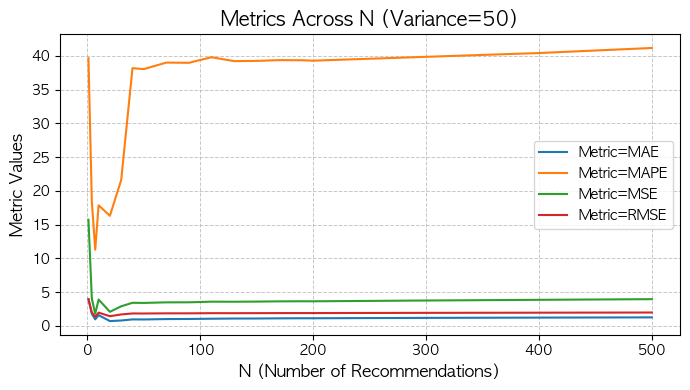

In [317]:
# Define parameters
variances = [0, 50, 80]  # List of variances to compare
n_values = sorted(
    list(range(1, 10, 3)) +            # 1부터 9까지 3씩 증가
    list(range(10, 50, 10)) +          # 10부터 50까지 10씩 증가
    list(range(50, 200, 20)) +         # 50부터 200까지 20씩 증가
    list(range(200, 501, 100))         # 200부터 500까지 100씩 증가
)

recommender = RandomRecommender(movies_df, rates_df)

# Part 1: Metrics Across N for Single Variance
single_variance = 50
results_single_df = run_experiment_for_variance(recommender, rates_df, single_variance, n_values)

# Melt for visualization (all metrics)
melted_single_df = results_single_df.melt(
    id_vars=["n"],
    value_vars=["MAE", "MSE", "RMSE", "MAPE"],
    var_name="Metric",
    value_name="Value"
)

Visualization.draw_line_chart(
    melted_single_df,
    x_column="n",
    y_column="Value",
    hue_column="Metric",
    title=f"Metrics Across N (Variance={single_variance})",
    xlabel="N (Number of Recommendations)",
    ylabel="Metric Values"
)

In [318]:
# Compare by Variation


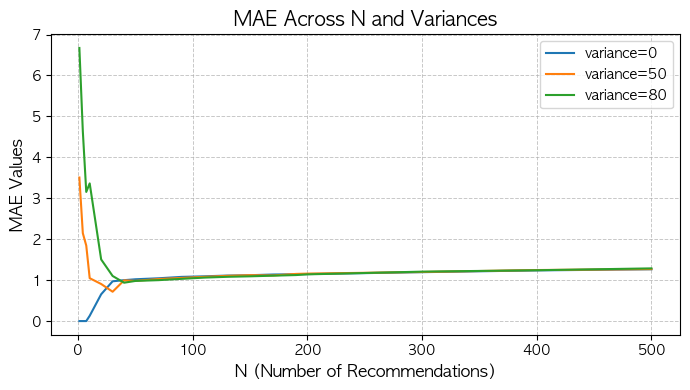

In [319]:

# Part 2: Compare Metric by Variances
all_results = []

for variance in variances:
    results_df = run_experiment_for_variance(recommender, rates_df, variance, n_values)
    all_results.append(results_df)

combined_results_df = pd.concat(all_results, ignore_index=True)

# Select one metric to plot
metric_to_plot = "MAE"
melted_combined_df = combined_results_df.melt(
    id_vars=["n", "variance"],
    value_vars=[metric_to_plot],
    var_name="Metric",
    value_name="Value"
)

Visualization.draw_line_chart(
    melted_combined_df,
    x_column="n",
    y_column="Value",
    hue_column="variance",
    title=f"{metric_to_plot} Across N and Variances",
    xlabel="N (Number of Recommendations)",
    ylabel=f"{metric_to_plot} Values"
)
